# Plot graph clutering results on fuzzy union graph (from UMAP)

The goal of this notebook is to produce plots for slides


In [2]:
!git branch

* master


In [3]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [4]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

from partition_igraph import community_ecg as ecg
from community import community_louvain, modularity
import leidenalg as la
import igraph as ig

sns.set()

# Clustering metric eval

To make things easier later we will write some short functions to evaluate clusterings (with some special handling of singleton clusters or noise points for clusterign algorithms that support such things), and to plot the results for easy comparison.

In [5]:
def eval_clusters(cluster_labels0, true_labels, raw_data, cluster_method="None", min_cluster_size=1):
    cluster_labels = cluster_labels0.copy()
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes <= min_cluster_size): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes < min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if (np.any(cluster_labels < 0)): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [6]:
def run_graph_clustering_algorithm(algo_list, G, weight = 'weight'):
    clusterings = dict()
    for algo in algo_list:
        #print(f"Running {algo}...")
        if algo == 'Louvain':
            clusterings[algo] = G.community_multilevel()
        elif algo == 'Louvain \n+ weight':
            clusterings[algo] = G.community_multilevel(weights = weight)
        elif algo == 'Label \nPropagation':
            clusterings[algo] = G.community_label_propagation()
        elif algo == 'ECG':
            clusterings[algo] = G.community_ecg()
        elif algo == 'Leiden':
            clusterings[algo] = la.find_partition(G, la.ModularityVertexPartition)
        elif algo == 'Leiden \n+ weight':
            clusterings[algo] = la.find_partition(G, la.ModularityVertexPartition, weights=weight)
            
        cluster_labels = {algo:np.array(cluster.membership) for algo, cluster in clusterings.items()}
    return(clusterings, cluster_labels)       

In [7]:
def evaluation_dataframe(cluster_labels, true_labels, raw_data, min_cluster_size=1):
    eval_results = pd.DataFrame(
        [
            eval_clusters(algo_labels, true_labels, raw_data, cluster_method=algo, min_cluster_size=min_cluster_size)
            for algo, algo_labels in cluster_labels.items() 
        ]
    )
    return(eval_results)

In [8]:
def evaluate_on_non_noise(clustering_labels_dict, skip_eval):
    clustering_noise = dict()
    for name, labels in clustering_labels_dict.items():
        new_labels = labels.copy()
        new_labels[skip_eval] = -1
        clustering_noise[name] = new_labels
    return(clustering_noise)

In [9]:
def print_summary(cluster_labels, G):
    for method, cluster in cluster_labels.items():
        print(f"{method}: \n\tModularity: {G.modularity(cluster):.2f}, \n\tPartition size: {1+max(cluster)}") 

In [10]:
algo_list = ['Louvain', 'Louvain \n+ weight', 'Label \nPropagation', 'ECG', 'Leiden', 'Leiden \n+ weight']
algo_list = ['Label \nPropagation', 'Louvain',  'ECG', 'Leiden']

# Compare graph algorithms performance on different graph constructions

In [11]:
def graph_clustering_on_graph_variants(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))

    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
    ari = adjusted_rand_score(targets, hd_umap_labels)
    ami = adjusted_mutual_info_score(targets, hd_umap_labels)
    print(f'{sum(hd_umap_labels<0)} noise vertices according to HDBSCAN')

    results = []
    # Graph from fuzzy union
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=1)
    clusterings, clustering_labels  = run_graph_clustering_algorithm(algo_list, G)
    graph_results = evaluation_dataframe(clustering_labels, targets, raw_data, min_cluster_size=5)
    graph_results_union = graph_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
    graph_results_union["Graph"] = 'Fuzzy Union'
    results.append(graph_results_union)

    results_df = pd.concat(results)

    return(results_df[results_df['Score Type']=='ARI'], ari)

In [12]:
import warnings
warnings.filterwarnings('ignore')
results = dict()
ARI = dict()
for i in range(5):
    results[i], ARI[i] = graph_clustering_on_graph_variants(dataset_id=i)

## pendigits

37 noise vertices according to HDBSCAN


## coil

14 noise vertices according to HDBSCAN


## mnist

483 noise vertices according to HDBSCAN


## usps

4 noise vertices according to HDBSCAN


## buildings

363 noise vertices according to HDBSCAN


In [13]:
results

{0:                 Method  Pct Clustered Score Type     Score        Graph
 0  Label \nPropagation            1.0        ARI  0.482163  Fuzzy Union
 1              Louvain            1.0        ARI  0.882375  Fuzzy Union
 2                  ECG            1.0        ARI  0.710837  Fuzzy Union
 3               Leiden            1.0        ARI  0.886081  Fuzzy Union,
 1:                 Method  Pct Clustered Score Type     Score        Graph
 0  Label \nPropagation        0.96875        ARI  0.202431  Fuzzy Union
 1              Louvain        1.00000        ARI  0.748548  Fuzzy Union
 2                  ECG        1.00000        ARI  0.449234  Fuzzy Union
 3               Leiden        1.00000        ARI  0.742911  Fuzzy Union,
 2:                 Method  Pct Clustered Score Type     Score        Graph
 0  Label \nPropagation            1.0        ARI  0.560835  Fuzzy Union
 1              Louvain            1.0        ARI  0.803996  Fuzzy Union
 2                  ECG            1.0  

In [14]:
ARI

{0: 0.9185149200427103,
 1: 0.7910813366998825,
 2: 0.8987078065717921,
 3: 0.8824676944734986,
 4: 0.2458851298996959}

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

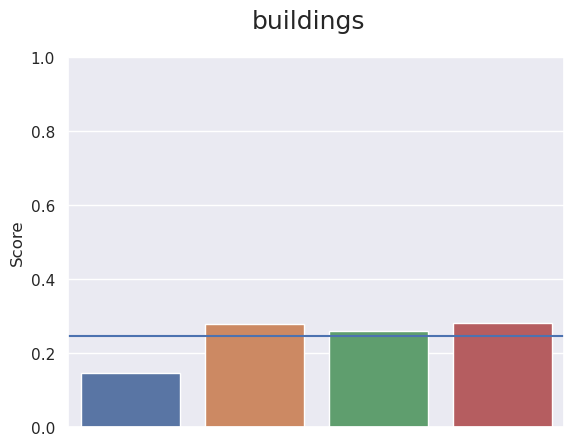

In [43]:
for i in range(5):
    plt.clf()
    fig, ax = plt.subplots()
    fig.suptitle(data_set_list[i], fontsize=18)
    ax = sns.barplot(data=results[i], y='Score', x='Method', hue='Method', dodge=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.set(ylim=(0,1))
    ax.axhline(ARI[i], label='UMAP+HDBSCAN')
    ax.legend_.remove()
    plt.savefig(f'figures/fuzzyUnion_graphclust_{data_set_list[i]}.png')

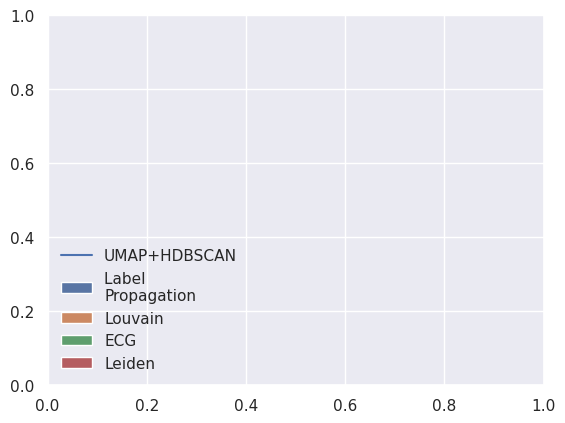

In [44]:
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False)

In [46]:
def export_legend(legend, filename="figures/fuzzyUnion_graphclust_legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()